# **Lending Club Loan Charge-off Prediction**
In this project, I explored and visualized a Lending Club historical [dataset](https://www.kaggle.com/wordsforthewise/lending-club), and built a machine learning model to predict the probability a loan will charge off in the future. 

# **Part 1: Data Loading and Preprocessing**

## 1.1 Import necessary packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
%matplotlib inline
pd.set_option('display.max_colwidth', 1000)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1.2 Load data from google drive

In [ ]:
from google.colab import drive
drive.mount('./ggDrive')

#df_loan = pd.read_csv('./ggDrive/My Drive/dataSet/LendingClub/loan-clean-version.csv')
df_loan = pd.read_csv('./ggDrive/My Drive/dataSet/LendingClub/accepted_2007_to_2018Q4.csv')

## 1.3 Exploratory Data Analysis

### 1.3.1 A first glance of data

In [ ]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [ ]:
df_loan.sample(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
1049595,72783555,NaN,9000.0,9000.0,9000.0,36 months,7.39,279.51,A,A4,Payroll Specialist,3 years,RENT,55000.0,Verified,Feb-2016,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=72783555,NaN,credit_card,NaN,224xx,VA,17.67,6.0,May-2000,685.0,689.0,2.0,18.0,NaN,14.0,0.0,9491.0,49.2,24.0,w,0.00,0.00,...,70958.0,74224.0,13600.0,51658.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1076069,70673871,NaN,25000.0,25000.0,25000.0,36 months,11.47,824.05,B,B5,Senior Customer Service Engineer,10+ years,MORTGAGE,125000.0,Not Verified,Feb-2016,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=70673871,NaN,debt_consolidation,Debt consolidation,974xx,OR,28.58,0.0,Feb-1990,710.0,714.0,0.0,44.0,NaN,17.0,0.0,49420.0,59.0,28.0,w,0.00,0.00,...,437417.0,81351.0,67200.0,61217.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
563989,118185963,NaN,30000.0,30000.0,30000.0,60 months,30.94,988.00,G,G4,CRAA,9 years,RENT,62000.0,Source Verified,Sep-2017,Current,n,https://lendingclub.com/browse/loanDetail.action?loan_id=118185963,NaN,debt_consolidation,Debt consolidation,380xx,TN,33.40,0.0,Jan-1994,665.0,669.0,2.0,52.0,NaN,16.0,0.0,7940.0,46.2,26.0,w,25180.35,25180.35,...,71122.0,40923.0,7500.0,53922.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1456480,142070276,NaN,12000.0,12000.0,12000.0,36 months,8.46,378.59,A,A5,Crew leader Server,10+ years,MORTGAGE,55000.0,Source Verified,Oct-2018,Current,n,https://lendingclub.com/browse/loanDetail.action?loan_id=142070276,NaN,debt_consolidation,Debt consolidation,325xx,FL,3.46,0.0,Dec-2013,670.0,674.0,0.0,NaN,NaN,7.0,0.0,3713.0,8.3,7.0,w,10509.18,10509.18,...,44700.0,3713.0,18100.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
39450,65865597,NaN,27000.0,27000.0,27000.0,60 months,21.99,745.56,F,F1,Maintenance supervisor,9 years,MORTGAGE,80000.0,Source Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=65865597,NaN,debt_consolidation,Debt consolidation,245xx,VA,10.88,0.0,Apr-2005,675.0,679.0,1.0,24.0,NaN,9.0,0.0,13856.0,63.9,22.0,w,0.00,0.00,...,177153.0,25891.0,9800.0,14315.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,INTEREST ONLY-3 MONTHS DEFERRAL,EXCESSIVE_OBLIGATIONS,COMPLETED,3.0,364.99,Dec-2017,Mar-2018,Jan-2018,3.0,11.0,In Grace Period,1094.97,19673.24,744.66,Cash,N,NaN,

### 1.3.2 Response Variable

In [ ]:
df_loan['loan_status'].value_counts(dropna=False)

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
NaN                                                         33
Name: loan_status, dtype: int64

#### We only keep the loans with status "Fully Paid" or "Charged Off" 

In [ ]:
df_loan = df_loan.loc[df_loan['loan_status'].isin(['Fully Paid', 'Charged Off'])]
df_loan.shape

(1345310, 151)

#### Visualize the distribution of response variable

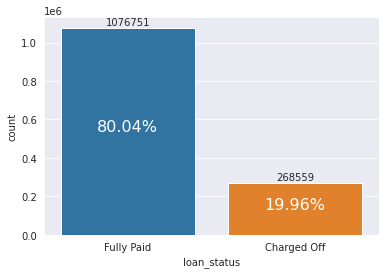

In [ ]:
ax = sns.countplot(x='loan_status', data=df_loan)
for p in ax.patches:
  hgt = p.get_height()
  x = p.get_x() + p.get_width() / 2
  ax.text(x, hgt / 2, f'{hgt / df_loan.shape[0] * 100:.2f}%', color='white', fontsize=16, ha='center')
  ax.text(x, hgt + df_loan.shape[0] * 0.01, f'{hgt}', ha='center')

### 1.3.3 Drop features with 30+% missing values

Percentage of missing values over each feature

Will drop 58 features with 30% and more missing data


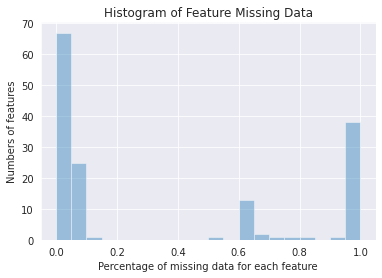

In [ ]:
miss_perc = df_loan.isnull().mean()

# visualize the distribution
sns.distplot(miss_perc, bins=20, kde=False)
plt.xlabel('Percentage of missing data for each feature')
plt.ylabel('Numbers of features')
plt.title('Histogram of Feature Missing Data')

# Drop features with more than 30% missing data
drop_list = sorted(list(miss_perc[miss_perc >= 0.3].index))
#print(drop_list)
print(f'Will drop {len(drop_list)} features with 30% and more missing data')

In [ ]:
df_loan.drop(labels=drop_list, axis=1, inplace=True)
print('data shape:', df_loan.shape)

data shape: (1345310, 93)


#### Drop features with 1 unique value

In [ ]:
nuniq = df_loan.nunique()
print(nuniq)
drop_list = list(nuniq[nuniq == 1].index)
df_loan.drop(labels=drop_list, axis=1, inplace=True)
print('Now the shape of df_loan is: {}'.format(df_loan.shape))

id                            1345310
loan_amnt                        1556
funded_amnt                      1556
funded_amnt_inv                  9016
term                                2
                               ...   
total_bc_limit                  17086
total_il_high_credit_limit     162548
hardship_flag                       1
disbursement_method                 2
debt_settlement_flag                2
Length: 93, dtype: int64
Now the shape of df_loan is: (1345310, 88)


### 1.3.4 Keep features only appear in LCdic.xlsx

In [ ]:
feat_dict = pd.read_excel('./ggDrive/My Drive/dataSet/LendingClub/LCdic.xlsx', index_col=0)
feat_dict.head()

,LoanStatNew,Description
0,addr_state,The state provided by the borrower in the loan application
1,annual_inc,The self-reported annual income provided by the borrower during registration.
2,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
3,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
4,collection_recovery_fee,post charge off collection fee


In [ ]:
feat_dict = dict(zip(feat_dict['LoanStatNew'], feat_dict['Description']))
print('addr_state:', feat_dict['addr_state'], len(feat_dict))

#import timeit

#%timeit a = dict(zip(df_dic['LoanStatNew'], df_dic['Description']))
#%timeit b = df_dic.set_index('LoanStatNew').to_dict()['Description']
#%timeit c = pd.Series(df_dic.Description.values, index=df_dic.LoanStatNew).to_dict()

addr_state: The state provided by the borrower in the loan application 78


In [ ]:
keep_list = sorted(list(set(feat_dict.keys()) & set(df_loan.columns) - {'loan_status'}))
df_loan = df_loan[keep_list + ['loan_status']]
print(df_loan.shape)
df_loan['relative numbers'] = ""
df_loan['y'] = (df_loan['loan_status'] == 'Charged Off').apply(np.uint8)

(1345310, 49)


### 1.3.5 Define functions to analyze features

In [ ]:
def featInfo(feat, feat_dict=feat_dict, hue_col='loan_status'):
  print(f'{feat}:\t{feat_dict[feat]}\n')

  print(df_loan.groupby(hue_col)[feat].describe(), '\n')

  df1 = df_loan.groupby(hue_col)[feat].agg(['size', 'count'])
  df1['missing'] = df1['size'] - df1['count']
  df1['missing %'] = df1['missing'] / df1['size'] * 100
  print(df1)

def featVis(feat, feat_type='categorical', hue_col='loan_status', numlog=False,\
            rotation=None, order=False, xlim=None, nxlabel=None, lblFunc=None):
  
  fig = plt.figure(figsize=[12, 4])
  if feat_type == 'categorical':
    df1 = df_loan.groupby([feat, hue_col]).size().reset_index()
    df1.columns = [feat, hue_col, 'count']
    df1['%'] = df1.groupby(feat).transform(lambda x: x / x.sum() * 100)
    df2 = df1.loc[df1[hue_col]=='Charged Off', :]
    if order:
      df2 = df2.sort_values(by='%', ascending=False)
    # bar plot 
    ax = sns.barplot(x=feat, y='count', hue=hue_col, \
                     hue_order=['Fully Paid', 'Charged Off'], data=df1)
    ax.set_yscale('log')
    if rotation:
      ax.tick_params(axis='x', rotation=rotation)
    # Charged Off percentage
    ax2 = ax.twinx()
    ax2.grid(False)
    ax2 = sns.pointplot(x=feat, y='%', color='red', data=df2)
    ax2.set_ylim([0, 105])
    ax2.set_ylabel('Percentage of "Charged Off"', color='r')
    if lblFunc:
      lbls = [lblFunc(lbl) for lbl in ax.get_xticklabels()]
      _ = ax.set_xticklabels(lbls)
    if nxlabel:
      ax2.xaxis.set_major_locator(plt.MaxNLocator(nxlabel))
    print(df1)
  elif feat_type == 'numerical':
    feat2 = feat
    if numlog:
      feat2 = 'log1p_' + feat
      belowZero = df_loan[feat][df_loan[feat] < 0]
      if len(belowZero) > 0:
        print(f"There are {len(belowZero)} values below zero: {belowZero}")
      df_loan[feat2] = df_loan[feat].apply(lambda x: np.NaN if x is None else np.log1p(max(x, 0)))
    ax = sns.violinplot(x=feat2, y='relative numbers', hue=hue_col, split=True, \
                        scale='count', data=df_loan)
    if xlim:
      ax.set_xlim(xlim)
  else:
    print("Please input the correct feat_type.")

def encoding(feat, col_grp, cat_thresh=10, betaT=10, numlog=False):
  if len(col_grp) == 1:
    feat2 = feat
    if numlog:
      feat2 = 'log1p_' + feat
      drop_list.add(feat)
    #print(df_loan[feat2].isnull().sum())
    if df_loan[feat2].isnull().sum() > 0:
      df_loan[feat2] = df_loan.groupby('loan_status', sort=False)[feat2].apply(lambda x: x.fillna(x.mean()))
    col_grp[0].add(feat2)      
  elif len(col_grp) == 2:
    df_loan[feat] = df_loan[feat].astype(str)
    if df_loan[feat].nunique() <= cat_thresh:
      col_grp[0].add(feat)
    else: # beta target encoding
      prior = df_loan['y'].mean()
      df_loan[feat] = df_loan.groupby(feat)['y'].transform(lambda x: x.mean() if x.size >= betaT \
                                                           else (x.sum() + (betaT - x.size) * prior) / betaT)
      col_grp[1].add(feat)

### 1.3.6 Investigate features one by one

In [ ]:
num_cols = [set()]
cat_cols = [set(), set()] # [cat_onehot, cat_target]
drop_list = {'loan_status', 'relative numbers'}
#print(num_cols, cat_cols)

#### 1.3.6.0 acc_now_delinq

In [ ]:
featInfo(keep_list[0])

acc_now_delinq:	The number of accounts on which the borrower is now delinquent.

                 count      mean       std  min  25%  50%  75%   max
loan_status                                                         
Charged Off   268559.0  0.005656  0.081923  0.0  0.0  0.0  0.0   6.0
Fully Paid   1076751.0  0.004893  0.075926  0.0  0.0  0.0  0.0  14.0 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


    acc_now_delinq  loan_status    count           %
0              0.0  Charged Off   267152   19.952023
1              0.0   Fully Paid  1071820   80.047977
2              1.0  Charged Off     1318   22.058577
3              1.0   Fully Paid     4657   77.941423
4              2.0  Charged Off       73   23.856209
5              2.0   Fully Paid      233   76.143791
6              3.0  Charged Off       12   28.571429
7              3.0   Fully Paid       30   71.428571
8              4.0  Charged Off        2   20.000000
9              4.0   Fully Paid        8   80.000000
10             5.0  Charged Off        1   33.333333
11             5.0   Fully Paid        2   66.666667
12             6.0  Charged Off        1  100.000000
13            14.0   Fully Paid        1  100.000000


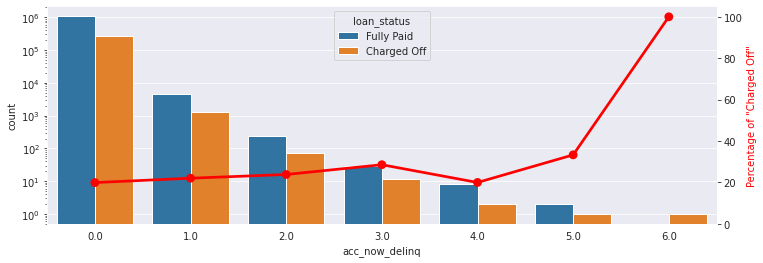

In [ ]:
featVis(keep_list[0])

In [ ]:
encoding(keep_list[0], cat_cols)

#### 1.3.6.1 addr_state

In [ ]:
featInfo(keep_list[1])

addr_state:	The state provided by the borrower in the loan application

               count unique top    freq
loan_status                            
Charged Off   268559     51  CA   38540
Fully Paid   1076751     51  CA  157988 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


    addr_state  loan_status  count          %
0           AK  Charged Off    627  19.655172
1           AK   Fully Paid   2563  80.344828
2           AL  Charged Off   3926  23.632095
3           AL   Fully Paid  12687  76.367905
4           AR  Charged Off   2420  24.086792
..         ...          ...    ...        ...
97          WI   Fully Paid  14478  81.648996
98          WV  Charged Off    757  15.518655
99          WV   Fully Paid   4121  84.481345
100         WY  Charged Off    490  16.769336
101         WY   Fully Paid   2432  83.230664

[102 rows x 4 columns]


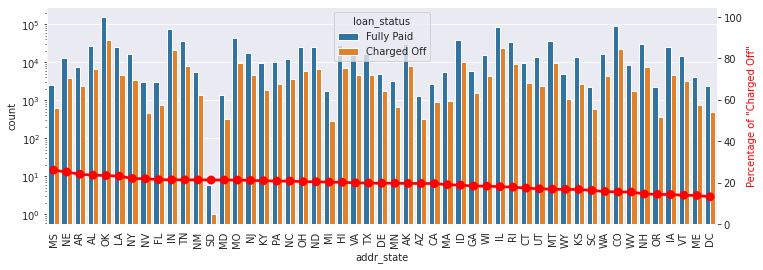

In [ ]:
featVis(keep_list[1], rotation=90, order=True)

In [ ]:
encoding(keep_list[1], cat_cols)

#### 1.3.6.2 annual_inc

In [ ]:
featInfo(keep_list[2])

annual_inc:	The self-reported annual income provided by the borrower during registration.

                 count          mean  ...      75%         max
loan_status                           ...                     
Charged Off   268559.0  70400.743283  ...  85000.0   9500000.0
Fully Paid   1076751.0  77705.945505  ...  93000.0  10999200.0

[2 rows x 8 columns] 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


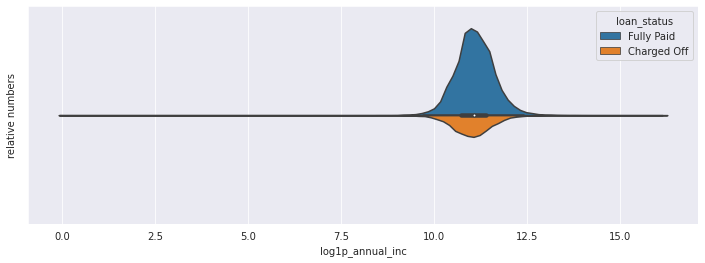

In [ ]:
featVis(keep_list[2], 'numerical', numlog=True)

In [ ]:
encoding(keep_list[2], num_cols, numlog=True)

#### 1.3.6.3 application type

In [ ]:
featInfo(keep_list[3])

application_type:	Indicates whether the loan is an individual application or a joint application with two co-borrowers

               count unique         top     freq
loan_status                                     
Charged Off   268559      2  Individual   262215
Fully Paid   1076751      2  Individual  1057295 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


  application_type  loan_status    count          %
0       Individual  Charged Off   262215  19.872150
1       Individual   Fully Paid  1057295  80.127850
2        Joint App  Charged Off     6344  24.589147
3        Joint App   Fully Paid    19456  75.410853


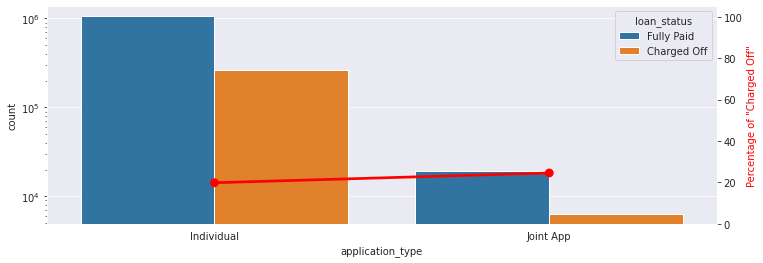

In [ ]:
featVis(keep_list[3])

In [ ]:
encoding(keep_list[3], cat_cols)

#### 1.3.6.4 collection_recovery_fee

In [ ]:
featInfo(keep_list[4])

collection_recovery_fee:	post charge off collection fee

                 count        mean         std  ...   50%        75%       max
loan_status                                     ...                           
Charged Off   268559.0  201.526243  329.318151  ...  80.1  283.56075  7174.719
Fully Paid   1076751.0    0.000000    0.000000  ...   0.0    0.00000     0.000

[2 rows x 8 columns] 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


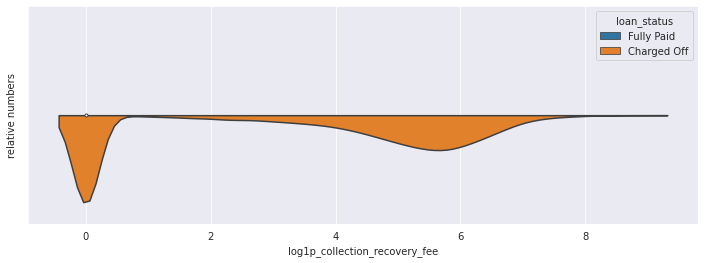

In [ ]:
featVis(keep_list[4], 'numerical', numlog=True)

In [ ]:
encoding(keep_list[4], num_cols, numlog=True)

#### 1.3.6.5 collections_12_mths_ex_med

In [ ]:
featInfo(keep_list[5])

collections_12_mths_ex_med:	Number of collections in 12 months excluding medical collections

                 count      mean       std  min  25%  50%  75%   max
loan_status                                                         
Charged Off   268553.0  0.021850  0.161930  0.0  0.0  0.0  0.0   9.0
Fully Paid   1076701.0  0.015957  0.142901  0.0  0.0  0.0  0.0  20.0 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268553        6   0.002234
Fully Paid   1076751  1076701       50   0.004644


    collections_12_mths_ex_med  loan_status    count           %
0                          0.0  Charged Off   263189   19.875126
1                          0.0   Fully Paid  1061024   80.124874
2                          1.0  Charged Off     4951   25.387140
3                          1.0   Fully Paid    14551   74.612860
4                          2.0  Charged Off      354   27.399381
5                          2.0   Fully Paid      938   72.600619
6                          3.0  Charged Off       39   25.490196
7                          3.0   Fully Paid      114   74.509804
8                          4.0  Charged Off       14   26.415094
9                          4.0   Fully Paid       39   73.584906
10                         5.0  Charged Off        3   16.666667
11                         5.0   Fully Paid       15   83.333333
12                         6.0  Charged Off        2   22.222222
13                         6.0   Fully Paid        7   77.777778
14                       

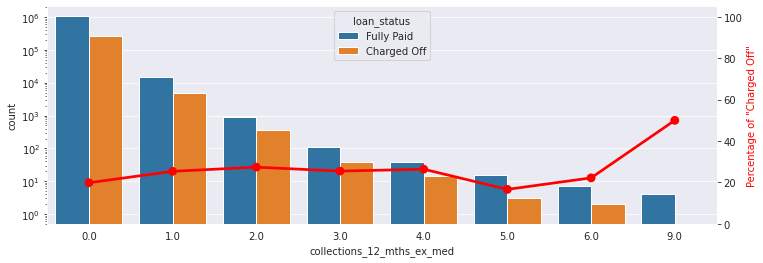

In [ ]:
featVis(keep_list[5])

In [ ]:
encoding(keep_list[5], cat_cols)

#### 1.3.6.6 deling_2yrs

In [ ]:
featInfo(keep_list[6])

delinq_2yrs:	The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years

                 count      mean       std  min  25%  50%  75%   max
loan_status                                                         
Charged Off   268559.0  0.351867  0.938114  0.0  0.0  0.0  0.0  27.0
Fully Paid   1076751.0  0.309296  0.862135  0.0  0.0  0.0  0.0  39.0 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


    delinq_2yrs  loan_status   count           %
0           0.0  Charged Off  212945   19.607130
1           0.0   Fully Paid  873114   80.392870
2           1.0  Charged Off   35899   20.833116
3           1.0   Fully Paid  136418   79.166884
4           2.0  Charged Off   11202   22.213849
5           2.0   Fully Paid   39226   77.786151
6           3.0  Charged Off    4243   23.135224
7           3.0   Fully Paid   14097   76.864776
8           4.0  Charged Off    1895   23.328819
9           4.0   Fully Paid    6228   76.671181
10          5.0  Charged Off     992   23.720708
11          5.0   Fully Paid    3190   76.279292
12          6.0  Charged Off     520   22.598870
13          6.0   Fully Paid    1781   77.401130
14          7.0  Charged Off     319   24.747867
15          7.0   Fully Paid     970   75.252133
16          8.0  Charged Off     174   22.924901
17          8.0   Fully Paid     585   77.075099
18          9.0  Charged Off     119   24.895397
19          9.0   Fu

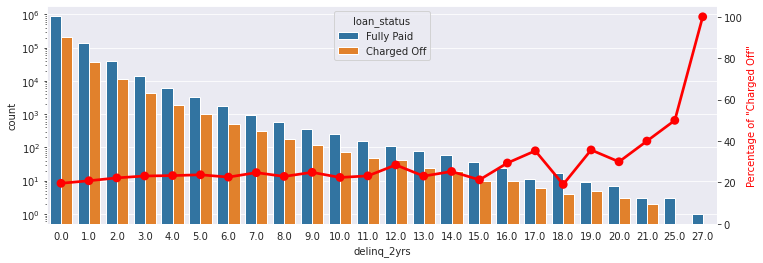

In [ ]:
featVis(keep_list[6])

In [ ]:
encoding(keep_list[6], cat_cols)

#### 1.3.6.7 dti

In [ ]:
featInfo(keep_list[7])

dti:	A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

                 count       mean        std  min    25%    50%    75%    max
loan_status                                                                  
Charged Off   268488.0  20.171196  11.831747  0.0  13.55  19.76  26.31  999.0
Fully Paid   1076448.0  17.811629  10.935927 -1.0  11.43  17.11  23.44  999.0 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268488       71   0.026437
Fully Paid   1076751  1076448      303   0.028140


There are 2 values below zero: 1014615   -1.0
1681348   -1.0
Name: dti, dtype: float64


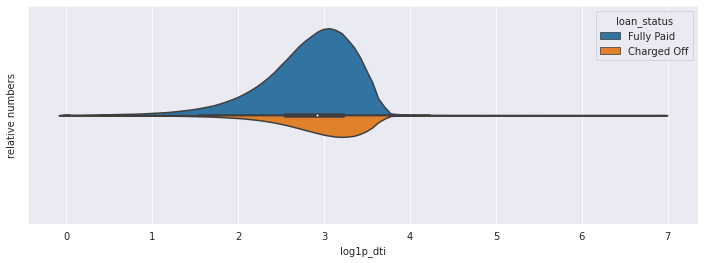

In [ ]:
featVis(keep_list[7], 'numerical', numlog=True)

In [ ]:
encoding(keep_list[7], num_cols, numlog=True)

#### 1.3.6.8 earliest_cr_line

In [ ]:
featInfo(keep_list[8])

earliest_cr_line:	The month the borrower's earliest reported credit line was opened

               count unique       top  freq
loan_status                                
Charged Off   268559    686  Aug-2001  1913
Fully Paid   1076751    735  Aug-2001  7478 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


     earliest_cr_line  loan_status  count          %
0                1960  Charged Off     74  24.342105
1                1960   Fully Paid    230  75.657895
2                1961  Charged Off     21  23.595506
3                1961   Fully Paid     68  76.404494
4                1962  Charged Off     38  28.358209
..                ...          ...    ...        ...
107              2013   Fully Paid   4300  72.537112
108              2014  Charged Off    665  26.739043
109              2014   Fully Paid   1822  73.260957
110              2015  Charged Off     65  19.877676
111              2015   Fully Paid    262  80.122324

[112 rows x 4 columns]


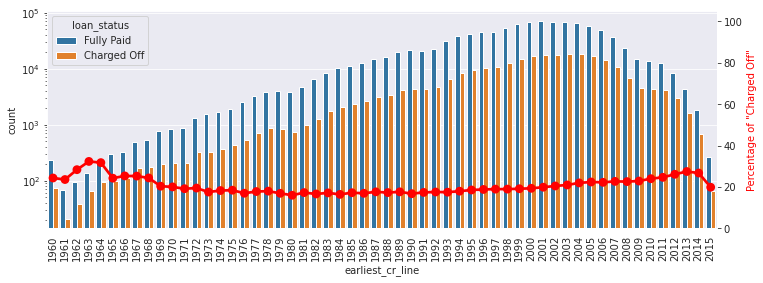

In [ ]:
df_loan[keep_list[8]] = df_loan[keep_list[8]].apply(lambda x: max(int(x[-4:]), 1960))
featVis(keep_list[8], rotation=90)

In [ ]:
encoding(keep_list[8], cat_cols)

#### 1.3.6.9 emp_length

In [ ]:
featInfo(keep_list[9])

emp_length:	Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.

               count unique        top    freq
loan_status                                   
Charged Off   247429     11  10+ years   83057
Fully Paid   1019370     11  10+ years  359142 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   247429    21130   7.867917
Fully Paid   1076751  1019370    57381   5.329087


   emp_length  loan_status   count          %
0      1 year  Charged Off   18198  20.564106
1      1 year   Fully Paid   70296  79.435894
2   10+ years  Charged Off   83057  18.782720
3   10+ years   Fully Paid  359142  81.217280
4     2 years  Charged Off   24114  19.807299
5     2 years   Fully Paid   97629  80.192701
6     3 years  Charged Off   21486  19.968958
7     3 years   Fully Paid   86111  80.031042
8     4 years  Charged Off   15900  19.737822
9     4 years   Fully Paid   64656  80.262178
10    5 years  Charged Off   16495  19.600970
11    5 years   Fully Paid   67659  80.399030
12    6 years  Charged Off   12140  19.351856
13    6 years   Fully Paid   50593  80.648144
14    7 years  Charged Off   11620  19.488796
15    7 years   Fully Paid   48004  80.511204
16    8 years  Charged Off   12100  19.933774
17    8 years   Fully Paid   48601  80.066226
18    9 years  Charged Off   10137  19.901054
19    9 years   Fully Paid   40800  80.098946
20   < 1 year  Charged Off   22182

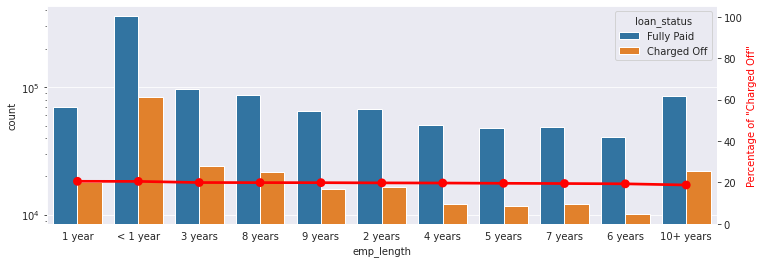

In [ ]:
featVis(keep_list[9], order=True)

In [ ]:
encoding(keep_list[9], cat_cols)

#### 1.3.6.10 emp_title (drop)

In [ ]:
featInfo(keep_list[10])

emp_title:	The job title supplied by the Borrower when applying for the loan.*

               count  unique      top   freq
loan_status                                 
Charged Off   246098   95763  Manager   4090
Fully Paid   1013427  317432  Teacher  17318 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   246098    22461   8.363525
Fully Paid   1076751  1013427    63324   5.881025


In [ ]:
# So many (317432) unique job titles!! doesn't make sense. drop this feature
drop_list. add(keep_list[10])

#### 1.3.6.11 fico_range_high

In [ ]:
featInfo(keep_list[11])

fico_range_high:	The upper boundary range the borrower’s FICO at loan origination belongs to.

                 count        mean        std  ...    50%    75%    max
loan_status                                    ...                     
Charged Off   268559.0  691.850171  25.948896  ...  684.0  704.0  850.0
Fully Paid   1076751.0  702.264062  32.834366  ...  694.0  719.0  850.0

[2 rows x 8 columns] 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


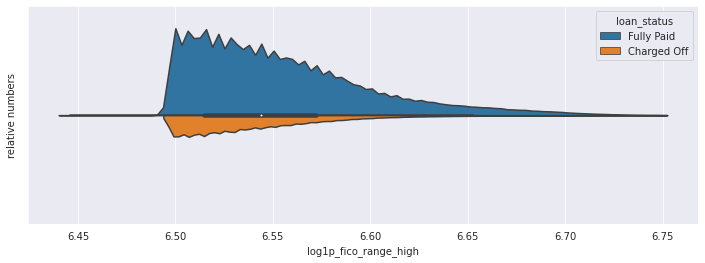

In [ ]:
featVis(keep_list[11], 'numerical', numlog=True)

#### 1.3.6.12 fico_range_low

In [ ]:
featInfo(keep_list[12])

fico_range_low:	The lower boundary range the borrower’s FICO at loan origination belongs to.

                 count        mean        std  ...    50%    75%    max
loan_status                                    ...                     
Charged Off   268559.0  687.850119  25.948579  ...  680.0  700.0  845.0
Fully Paid   1076751.0  698.263902  32.833650  ...  690.0  715.0  845.0

[2 rows x 8 columns] 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


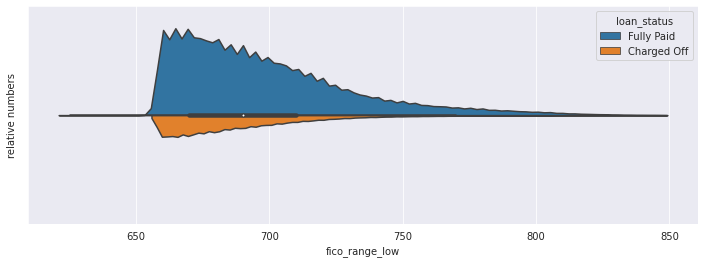

In [ ]:
featVis(keep_list[12], 'numerical')

In [ ]:
# I guess the high and low fico_range are correlated
print(df_loan[keep_list[11:13]].corr())

# only keep one feature
encoding(keep_list[11], num_cols, numlog=True)
drop_list.add(keep_list[12])

                 fico_range_high  fico_range_low
fico_range_high              1.0             1.0
fico_range_low               1.0             1.0


#### 1.3.6.13 funded_amnt

In [ ]:
featInfo(keep_list[13])

funded_amnt:	The total amount committed to that loan at that point in time.

                 count          mean          std  ...      50%      75%      max
loan_status                                        ...                           
Charged Off   268559.0  15557.059808  8810.986735  ...  14325.0  20400.0  40000.0
Fully Paid   1076751.0  14125.849732  8664.976863  ...  12000.0  20000.0  40000.0

[2 rows x 8 columns] 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


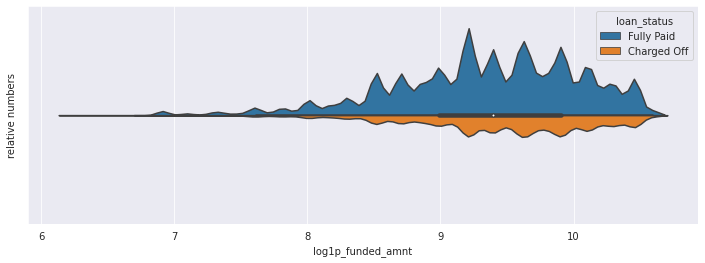

In [ ]:
featVis(keep_list[13], 'numerical', numlog=True)

#### 1.3.6.14 funded_amnt_inv

In [ ]:
featInfo(keep_list[14])

funded_amnt_inv:	The total amount committed by investors for that loan at that point in time.

                 count          mean          std  ...      50%      75%      max
loan_status                                        ...                           
Charged Off   268559.0  15531.253071  8814.731477  ...  14250.0  20375.0  40000.0
Fully Paid   1076751.0  14104.280646  8667.151787  ...  12000.0  20000.0  40000.0

[2 rows x 8 columns] 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


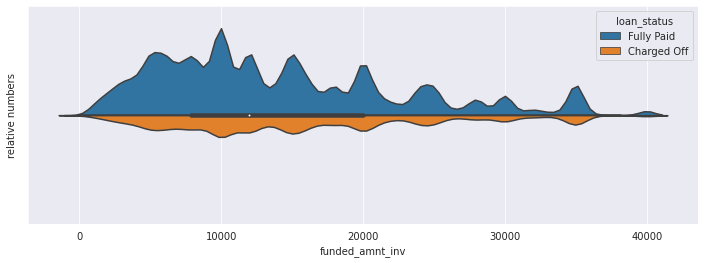

In [ ]:
featVis(keep_list[14], 'numerical')

In [ ]:
# I guess the two funded_amnt are correlated
print(df_loan[keep_list[13:15]].corr())

# only keep one feature
encoding(keep_list[13], num_cols, numlog=True)
drop_list.add(keep_list[14])

                 funded_amnt  funded_amnt_inv
funded_amnt         1.000000         0.999095
funded_amnt_inv     0.999095         1.000000


#### 1.3.6.15 grade

In [ ]:
featInfo(keep_list[15])

grade:	LC assigned loan grade

               count unique top    freq
loan_status                            
Charged Off   268559      7   C   85649
Fully Paid   1076751      7   B  340172 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


   grade  loan_status   count          %
0      A  Charged Off   14201   6.040665
1      A   Fully Paid  220889  93.959335
2      B  Charged Off   52569  13.385157
3      B   Fully Paid  340172  86.614843
4      C  Charged Off   85649  22.439649
5      C   Fully Paid  296037  77.560351
6      D  Charged Off   61054  30.382229
7      D   Fully Paid  139899  69.617771
8      E  Charged Off   36035  38.478377
9      E   Fully Paid   57615  61.521623
10     F  Charged Off   14491  45.202446
11     F   Fully Paid   17567  54.797554
12     G  Charged Off    4560  49.934297
13     G   Fully Paid    4572  50.065703


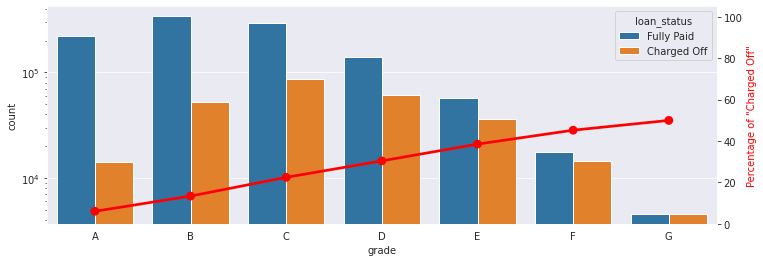

In [ ]:
featVis(keep_list[15])

In [ ]:
# we have another sub_grade feature
drop_list.add(keep_list[15])

#### 1.3.6.16 home_ownership

In [ ]:
featInfo(keep_list[16])

home_ownership:	The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.

               count unique       top    freq
loan_status                                  
Charged Off   268559      6      RENT  124074
Fully Paid   1076751      6  MORTGAGE  551048 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


   home_ownership  loan_status   count          %
0             ANY  Charged Off      56  19.580420
1             ANY   Fully Paid     230  80.419580
2        MORTGAGE  Charged Off  114531  17.207724
3        MORTGAGE   Fully Paid  551048  82.792276
4            NONE  Charged Off       7  14.583333
5            NONE   Fully Paid      41  85.416667
6           OTHER  Charged Off      27  18.750000
7           OTHER   Fully Paid     117  81.250000
8             OWN  Charged Off   29864  20.619753
9             OWN   Fully Paid  114968  79.380247
10           RENT  Charged Off  124074  23.216528
11           RENT   Fully Paid  410347  76.783472


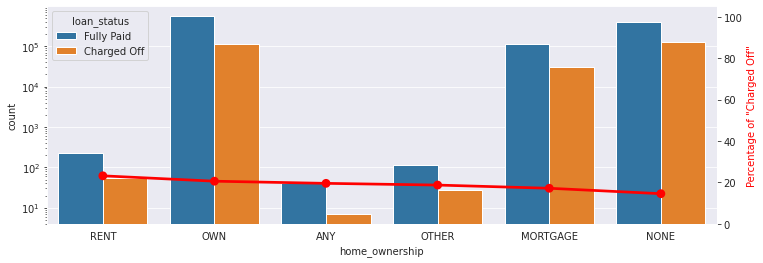

In [ ]:
featVis(keep_list[16], order=True)

In [ ]:
encoding(keep_list[16], cat_cols)

#### 1.3.6.17 id (will be dropped)

In [ ]:
featInfo(keep_list[17])

id:	A unique LC assigned ID for the loan listing.

               count   unique       top  freq
loan_status                                  
Charged Off   268559   268559  62914554     1
Fully Paid   1076751  1076751  14680062     1 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


In [ ]:
# all unique, will be dropped
drop_list.add(keep_list[17])

#### 1.3.6.18 initial_list_status

In [ ]:
featInfo(keep_list[18])

initial_list_status:	The initial listing status of the loan. Possible values are – W, F

               count unique top    freq
loan_status                            
Charged Off   268559      2   w  158440
Fully Paid   1076751      2   w  625570 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


  initial_list_status  loan_status   count          %
0                   f  Charged Off  110119  19.618564
1                   f   Fully Paid  451181  80.381436
2                   w  Charged Off  158440  20.208926
3                   w   Fully Paid  625570  79.791074


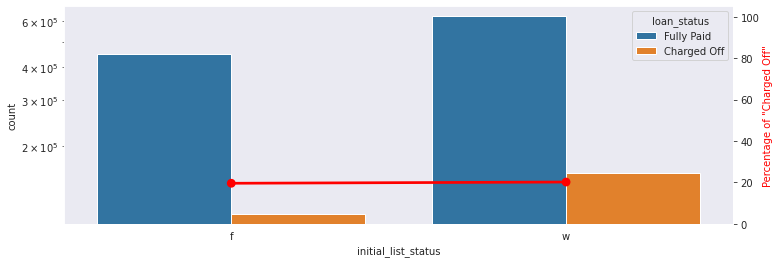

In [ ]:
featVis(keep_list[18])

In [ ]:
encoding(keep_list[18], cat_cols)

#### 1.3.6.19 inq_last_6mths

In [ ]:
featInfo(keep_list[19])

inq_last_6mths:	The number of inquiries in past 6 months (excluding auto and mortgage inquiries)

                 count      mean       std  min  25%  50%  75%  max
loan_status                                                        
Charged Off   268559.0  0.777985  1.012604  0.0  0.0  0.0  1.0  8.0
Fully Paid   1076750.0  0.624426  0.915594  0.0  0.0  0.0  1.0  8.0 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0   0.000000
Fully Paid   1076751  1076750        1   0.000093


    inq_last_6mths  loan_status   count          %
0              0.0  Charged Off  138042  17.917829
1              0.0   Fully Paid  632375  82.082171
2              1.0  Charged Off   78599  21.435253
3              1.0   Fully Paid  288082  78.564747
4              2.0  Charged Off   32822  23.994269
5              2.0   Fully Paid  103969  76.005731
6              3.0  Charged Off   13575  26.278093
7              3.0   Fully Paid   38084  73.721907
8              4.0  Charged Off    3901  28.141682
9              4.0   Fully Paid    9961  71.858318
10             5.0  Charged Off    1377  28.171031
11             5.0   Fully Paid    3511  71.828969
12             6.0  Charged Off     227  24.123273
13             6.0   Fully Paid     714  75.876727
14             7.0  Charged Off      12  25.000000
15             7.0   Fully Paid      36  75.000000
16             8.0  Charged Off       4  18.181818
17             8.0   Fully Paid      18  81.818182


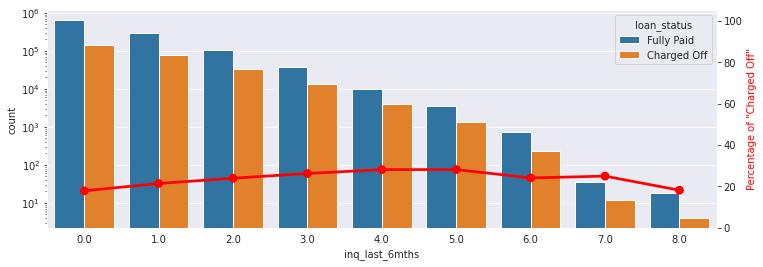

In [ ]:
featVis(keep_list[19])

In [ ]:
encoding(keep_list[19], cat_cols)

#### 1.3.6.20 installment

In [ ]:
featInfo(keep_list[20])

installment:	The monthly payment owed by the borrower if the loan originates.

                 count        mean         std  ...     50%     75%      max
loan_status                                     ...                         
Charged Off   268559.0  465.147994  262.774106  ...  402.83  605.31  1717.63
Fully Paid   1076751.0  431.323226  260.759563  ...  368.26  573.06  1719.83

[2 rows x 8 columns] 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


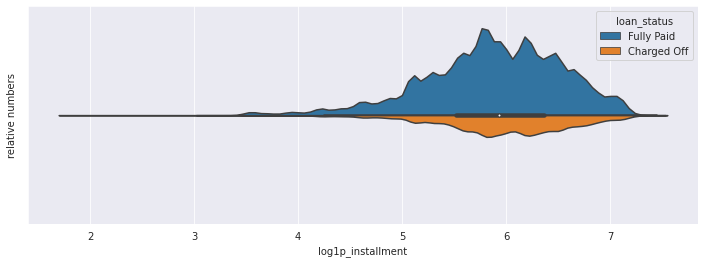

In [ ]:
featVis(keep_list[20], 'numerical', numlog=True)

In [ ]:
encoding(keep_list[20], num_cols, numlog=True)

#### 1.3.6.21 int_rate

In [ ]:
featInfo(keep_list[21])

int_rate:	Interest Rate on the loan

                 count       mean       std   min    25%    50%    75%    max
loan_status                                                                  
Charged Off   268559.0  15.710714  4.910387  5.31  12.29  15.05  18.55  30.99
Fully Paid   1076751.0  12.623288  4.527227  5.31   9.17  12.23  15.31  30.99 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


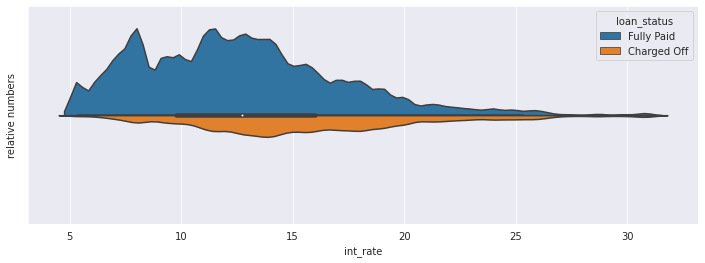

In [ ]:
featVis(keep_list[21], 'numerical')

In [ ]:
encoding(keep_list[21], num_cols)

#### 1.3.6.22 issue_d

In [ ]:
featInfo(keep_list[22])

issue_d:	The month which the loan was funded

               count unique       top   freq
loan_status                                 
Charged Off   268559    137  Mar-2016  10594
Fully Paid   1076751    139  Mar-2016  38343 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


issue_d:	The month which the loan was funded

               count unique        top   freq      first       last
loan_status                                                        
Charged Off   268559    137 2016-03-01  10594 2007-08-01 2018-12-01
Fully Paid   1076751    139 2016-03-01  38343 2007-06-01 2018-12-01 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0
       issue_d  loan_status  count           %
0   2007-06-01   Fully Paid      1  100.000000
1   2007-07-01   Fully Paid     30  100.000000
2   2007-08-01  Charged Off      7   21.212121
3   2007-08-01   Fully Paid     26   78.787879
4   2007-09-01  Charged Off      3   16.666667
..         ...          ...    ...         ...
271 2018-10-01   Fully Paid   2065   96.046512
272 2018-11-01  Charged Off     24    1.470588
273 2018-11-01   Fully Paid   1608   98.529412
274 2018-1

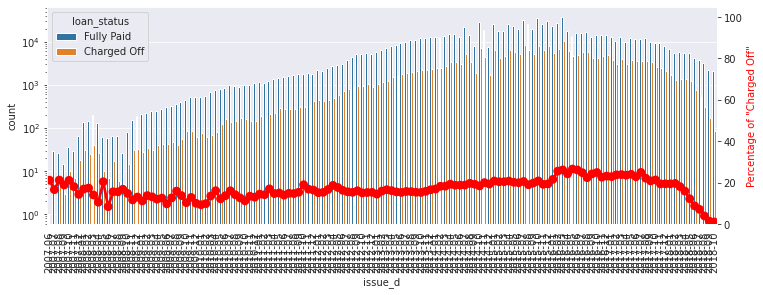

In [ ]:
df_loan[keep_list[22]] = pd.to_datetime(df_loan[keep_list[22]])
featInfo(keep_list[22])
featVis(keep_list[22], rotation=90, lblFunc=lambda x: x.get_text()[:7])

issue_month:	issue_month

                 count      mean       std  min  25%  50%   75%   max
loan_status                                                          
Charged Off   268559.0  6.502333  3.412404  1.0  4.0  7.0  10.0  12.0
Fully Paid   1076751.0  6.510471  3.459164  1.0  3.0  7.0  10.0  12.0 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0
    issue_month  loan_status   count          %
0             1  Charged Off   21599  19.101988
1             1   Fully Paid   91473  80.898012
2             2  Charged Off   19771  18.981557
3             2   Fully Paid   84388  81.018443
4             3  Charged Off   25413  20.147940
5             3   Fully Paid  100719  79.852060
6             4  Charged Off   22853  20.856606
7             4   Fully Paid   86719  79.143394
8             5  Charged Off   21766  20.836086
9           

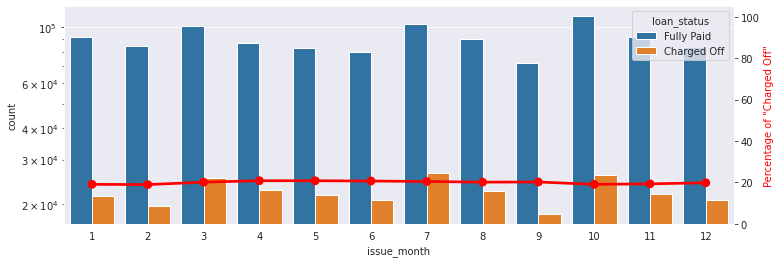

In [ ]:
df_loan['issue_month'] = df_loan[keep_list[22]].dt.month
feat_dict['issue_month'] = 'issue_month'

featInfo('issue_month')
featVis('issue_month')

In [ ]:
drop_list.add('issue_month')

#### 1.3.6.23 last_credit_pull_d

In [ ]:
featInfo(keep_list[23])

last_credit_pull_d:	The most recent month LC pulled credit for this loan

               count unique       top    freq
loan_status                                  
Charged Off   268549    114  Mar-2019   65726
Fully Paid   1076706    140  Mar-2019  405101 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268549       10   0.003724
Fully Paid   1076751  1076706       45   0.004179


last_credit_pull_d:	The most recent month LC pulled credit for this loan

               count unique        top    freq      first       last
loan_status                                                         
Charged Off   268549    114 2019-03-01   65726 2009-01-01 2019-03-01
Fully Paid   1076706    140 2019-03-01  405101 2007-05-01 2019-04-01 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268549       10   0.003724
Fully Paid   1076751  1076706       45   0.004179
    last_credit_pull_d  loan_status   count           %
0           2007-05-01   Fully Paid       1  100.000000
1           2007-06-01   Fully Paid      12  100.000000
2           2007-07-01   Fully Paid       1  100.000000
3           2007-08-01   Fully Paid      15  100.000000
4           2007-09-01   Fully Paid       2  100.000000
..                 ...          ...     ...         ...
249         2019-02-01  Charged Off   10695   14.288577


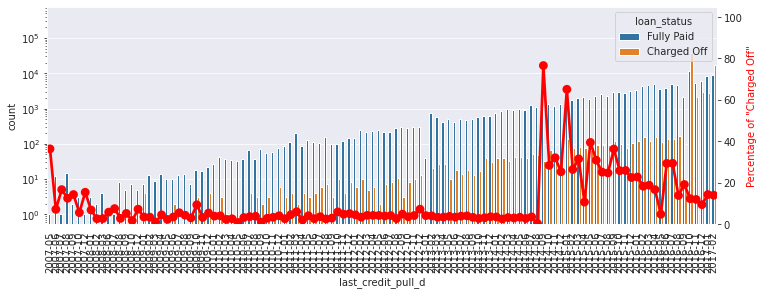

In [ ]:
df_loan[keep_list[23]] = pd.to_datetime(df_loan[keep_list[23]])
featInfo(keep_list[23])
featVis(keep_list[23], rotation=90, lblFunc=lambda x: x.get_text()[:7])

last_credit_pull_month:	last_credit_pull_month

                 count      mean       std  min  25%  50%   75%   max
loan_status                                                          
Charged Off   268549.0  5.988985  3.555586  1.0  3.0  5.0  10.0  12.0
Fully Paid   1076706.0  5.071831  3.414228  1.0  3.0  3.0   8.0  12.0 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268549       10   0.003724
Fully Paid   1076751  1076706       45   0.004179
    last_credit_pull_month  loan_status   count          %
0                      1.0  Charged Off   13683  13.664826
1                      1.0   Fully Paid   86450  86.335174
2                      2.0  Charged Off   32899  25.203202
3                      2.0   Fully Paid   97636  74.796798
4                      3.0  Charged Off   73773  14.285770
5                      3.0   Fully Paid  442636  85.714230
6                      4.0  Charged Off    8674  19.16863

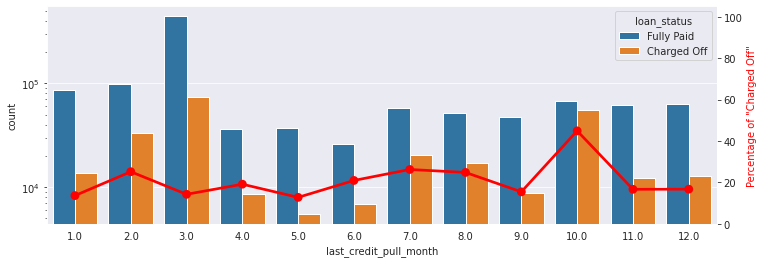

In [ ]:
df_loan['last_credit_pull_month'] = df_loan[keep_list[23]].dt.month
feat_dict['last_credit_pull_month'] = 'last_credit_pull_month'
featInfo('last_credit_pull_month')
featVis('last_credit_pull_month')

In [ ]:
encoding('last_credit_pull_month', cat_cols)
drop_list.add(keep_list[23])

#### 1.3.6.24 last_fico_range_high

In [ ]:
featInfo(keep_list[24])

last_fico_range_high:	The upper boundary range the borrower’s last FICO pulled belongs to.

                 count        mean        std  min    25%    50%    75%    max
loan_status                                                                   
Charged Off   268559.0  568.443236  54.125645  0.0  524.0  559.0  604.0  850.0
Fully Paid   1076751.0  704.433473  62.087151  0.0  674.0  709.0  744.0  850.0 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


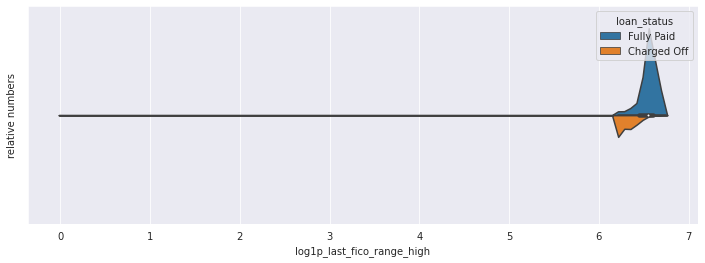

In [ ]:
featVis(keep_list[24], 'numerical', numlog=True)#, xlim=[420, 850])

In [ ]:
encoding(keep_list[24], num_cols, numlog=True)

#### 1.3.6.25 last_fico_range_low

In [ ]:
featInfo(keep_list[25])

last_fico_range_low:	The lower boundary range the borrower’s last FICO pulled belongs to.

                 count        mean         std  min    25%    50%    75%    max
loan_status                                                                    
Charged Off   268559.0  507.111752  189.695156  0.0  520.0  555.0  600.0  845.0
Fully Paid   1076751.0  698.336245   75.826180  0.0  670.0  705.0  740.0  845.0 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


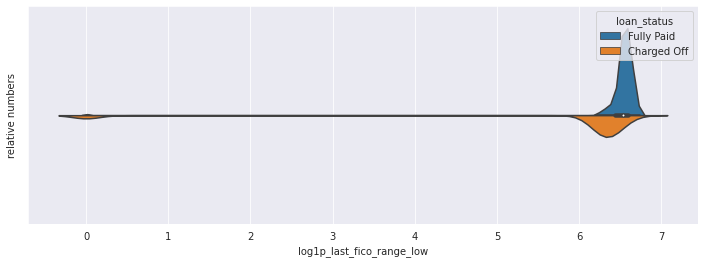

In [ ]:
featVis(keep_list[25], 'numerical', numlog=True)

In [ ]:
print(df_loan[keep_list[24:26]].corr())
encoding(keep_list[25], num_cols, numlog=True)

                      last_fico_range_high  last_fico_range_low
last_fico_range_high              1.000000             0.829519
last_fico_range_low               0.829519             1.000000


#### 1.3.6.26 last_pymnt_amnt

In [ ]:
featInfo(keep_list[26])

last_pymnt_amnt:	Last total payment amount received

                 count         mean          std  ...      50%        75%       max
loan_status                                       ...                              
Charged Off   268559.0   472.420366   570.906211  ...   389.98    600.000  39898.29
Fully Paid   1076751.0  6658.467296  7455.355009  ...  4116.09  10050.485  42192.05

[2 rows x 8 columns] 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


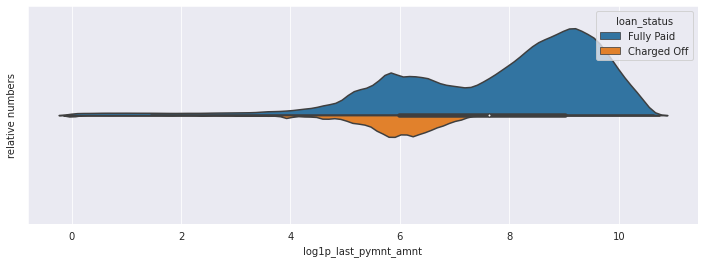

In [ ]:
featVis(keep_list[26], 'numerical', numlog=True)

In [ ]:
encoding(keep_list[26], num_cols, numlog=True)

#### 1.3.6.27 last_pymnt_d

In [ ]:
featInfo(keep_list[27])

last_pymnt_d:	Last month payment was received

               count unique       top   freq
loan_status                                 
Charged Off   266246    132  Aug-2018   7385
Fully Paid   1076751    135  Feb-2019  33627 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   266246     2313   0.861263
Fully Paid   1076751  1076751        0   0.000000


last_pymnt_d:	Last month payment was received

               count unique        top   freq      first       last
loan_status                                                        
Charged Off   266246    132 2018-08-01   7385 2008-03-01 2019-03-01
Fully Paid   1076751    135 2019-02-01  33627 2008-01-01 2019-03-01 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   266246     2313   0.861263
Fully Paid   1076751  1076751        0   0.000000
    last_pymnt_d  loan_status  count           %
0     2008-01-01   Fully Paid      4  100.000000
1     2008-02-01   Fully Paid      1  100.000000
2     2008-03-01  Charged Off      1   20.000000
3     2008-03-01   Fully Paid      4   80.000000
4     2008-04-01   Fully Paid     12  100.000000
..           ...          ...    ...         ...
262   2019-01-01   Fully Paid  30094   95.993620
263   2019-02-01  Charged Off    816    2.369132
264   2019-02-01   Fully Paid  33627  

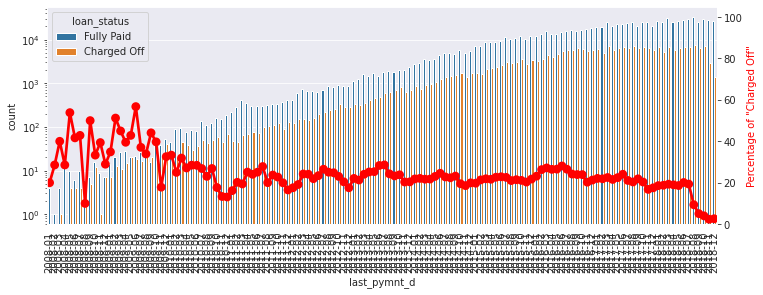

In [ ]:
df_loan[keep_list[27]] = pd.to_datetime(df_loan[keep_list[27]])
featInfo(keep_list[27])
featVis(keep_list[27], rotation=90, lblFunc=lambda x: x.get_text()[:7])

last_pymnt_month:	the last payment month

                 count      mean       std  min  25%  50%   75%   max
loan_status                                                          
Charged Off   266246.0  6.656438  3.326738  1.0  4.0  7.0   9.0  12.0
Fully Paid   1076751.0  6.361804  3.528561  1.0  3.0  6.0  10.0  12.0 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   266246     2313   0.861263
Fully Paid   1076751  1076751        0   0.000000
    last_pymnt_month  loan_status   count          %
0                1.0  Charged Off   20325  17.001539
1                1.0   Fully Paid   99223  82.998461
2                2.0  Charged Off   17425  14.222864
3                2.0   Fully Paid  105089  85.777136
4                3.0  Charged Off   22390  17.230234
5                3.0   Fully Paid  107556  82.769766
6                4.0  Charged Off   19477  20.770814
7                4.0   Fully Paid   74294  79.229186

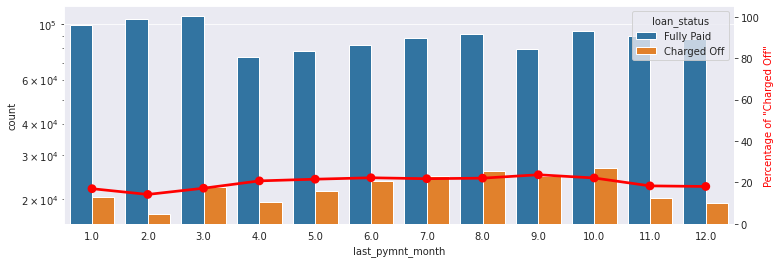

In [ ]:
df_loan['last_pymnt_month'] = df_loan['last_pymnt_d'].dt.month
feat_dict['last_pymnt_month'] = 'the last payment month'
featInfo('last_pymnt_month')
featVis('last_pymnt_month')

In [ ]:
drop_list.update(['last_pymnt_month', keep_list[27]])

#### 1.3.6.28 loan_amnt

In [ ]:
featInfo(keep_list[28])

loan_amnt:	The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

                 count          mean          std  ...      50%      75%      max
loan_status                                        ...                           
Charged Off   268559.0  15565.055444  8814.560077  ...  14350.0  20400.0  40000.0
Fully Paid   1076751.0  14134.369808  8669.028973  ...  12000.0  20000.0  40000.0

[2 rows x 8 columns] 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


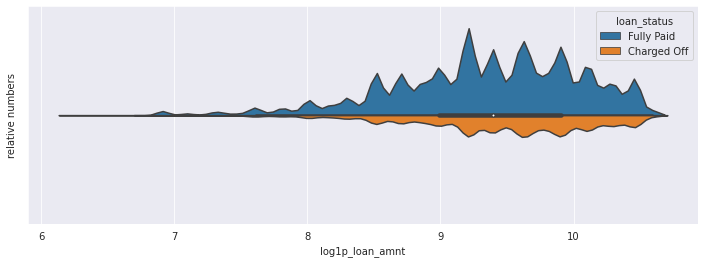

In [ ]:
featVis(keep_list[28], 'numerical', numlog=True)

In [ ]:
encoding(keep_list[28], num_cols, numlog=True)

#### 1.3.6.29 open_acc

In [ ]:
featInfo(keep_list[29])

open_acc:	The number of open credit lines in the borrower's credit file.

                 count       mean       std  min  25%   50%   75%   max
loan_status                                                            
Charged Off   268559.0  11.901269  5.637964  0.0  8.0  11.0  15.0  76.0
Fully Paid   1076751.0  11.516763  5.429354  0.0  8.0  11.0  14.0  90.0 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


     open_acc  loan_status  count           %
0         0.0  Charged Off      6   42.857143
1         0.0   Fully Paid      8   57.142857
2         1.0  Charged Off    134   26.171875
3         1.0   Fully Paid    378   73.828125
4         2.0  Charged Off    991   20.286592
..        ...          ...    ...         ...
145      82.0   Fully Paid      1  100.000000
146      84.0   Fully Paid      1  100.000000
147      86.0   Fully Paid      1  100.000000
148      88.0   Fully Paid      1  100.000000
149      90.0   Fully Paid      1  100.000000

[150 rows x 4 columns]


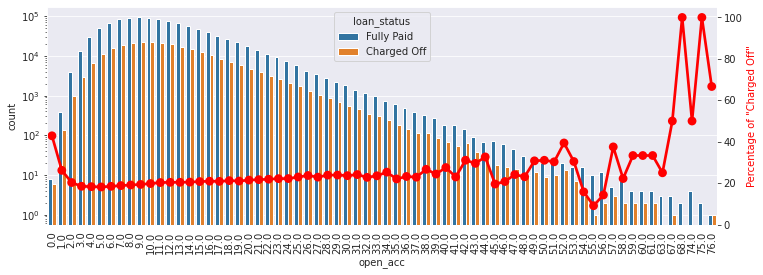

In [ ]:
featVis(keep_list[29], rotation=90)

In [ ]:
encoding(keep_list[29], cat_cols)

#### 1.3.6.30 pub_rec

In [ ]:
featInfo(keep_list[30])

pub_rec:	Number of derogatory public records

                 count      mean       std  min  25%  50%  75%   max
loan_status                                                         
Charged Off   268559.0  0.246843  0.656732  0.0  0.0  0.0  0.0  86.0
Fully Paid   1076751.0  0.207403  0.587118  0.0  0.0  0.0  0.0  63.0 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


    pub_rec  loan_status   count           %
0       0.0  Charged Off  216705   19.393248
1       0.0   Fully Paid  900720   80.606752
2       1.0  Charged Off   43155   22.619229
3       1.0   Fully Paid  147634   77.380771
4       2.0  Charged Off    5779   23.650501
5       2.0   Fully Paid   18656   76.349499
6       3.0  Charged Off    1681   22.719286
7       3.0   Fully Paid    5718   77.280714
8       4.0  Charged Off     650   24.714829
9       4.0   Fully Paid    1980   75.285171
10      5.0  Charged Off     280   22.116904
11      5.0   Fully Paid     986   77.883096
12      6.0  Charged Off     154   24.213836
13      6.0   Fully Paid     482   75.786164
14      7.0  Charged Off      59   20.848057
15      7.0   Fully Paid     224   79.151943
16      8.0  Charged Off      28   17.500000
17      8.0   Fully Paid     132   82.500000
18      9.0  Charged Off      19   22.891566
19      9.0   Fully Paid      64   77.108434
20     10.0  Charged Off      10   17.543860
21     10.

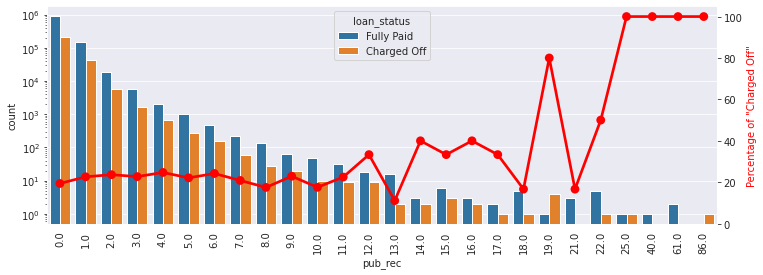

In [ ]:
featVis(keep_list[30], rotation=90)

In [ ]:
encoding(keep_list[30], cat_cols)

#### 1.3.6.31 purpose

In [ ]:
featInfo(keep_list[31])

purpose:	A category provided by the borrower for the loan request.

               count unique                 top    freq
loan_status                                            
Charged Off   268559     14  debt_consolidation  165014
Fully Paid   1076751     14  debt_consolidation  615307 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


               purpose  loan_status   count          %
0                  car  Charged Off    2141  14.679465
1                  car   Fully Paid   12444  85.320535
2          credit_card  Charged Off   49982  16.927042
3          credit_card   Fully Paid  245297  83.072958
4   debt_consolidation  Charged Off  165014  21.146938
5   debt_consolidation   Fully Paid  615307  78.853062
6          educational  Charged Off      56  17.177914
7          educational   Fully Paid     270  82.822086
8     home_improvement  Charged Off   15502  17.715762
9     home_improvement   Fully Paid   72002  82.284238
10               house  Charged Off    1587  21.880601
11               house   Fully Paid    5666  78.119399
12      major_purchase  Charged Off    5473  18.599830
13      major_purchase   Fully Paid   23952  81.400170
14             medical  Charged Off    3387  21.775749
15             medical   Fully Paid   12167  78.224251
16              moving  Charged Off    2214  23.354430
17        

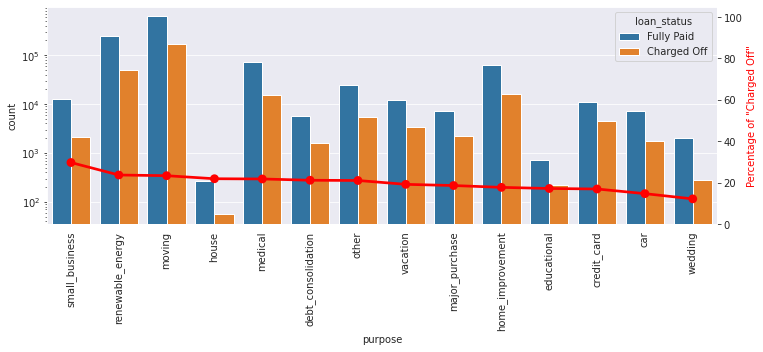

In [ ]:
featVis(keep_list[31], rotation=90, order=True)

In [ ]:
encoding(keep_list[31], cat_cols)

#### 1.3.6.32 recoveries

In [ ]:
featInfo(keep_list[32])

recoveries:	post charge off gross recovery

                 count         mean          std  ...    50%      75%       max
loan_status                                       ...                          
Charged Off   268559.0  1209.456926  1847.303239  ...  592.2  1723.81  39859.55
Fully Paid   1076751.0     0.000000     0.000000  ...    0.0     0.00      0.00

[2 rows x 8 columns] 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


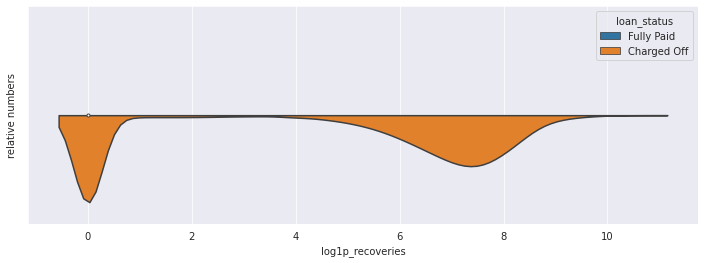

In [ ]:
featVis(keep_list[32], 'numerical', numlog=True)

In [ ]:
encoding(keep_list[32], num_cols, numlog=True)

#### 1.3.6.33 revol_bal

In [ ]:
featInfo(keep_list[33])

revol_bal:	Total credit revolving balance

                 count          mean           std  ...      50%      75%        max
loan_status                                         ...                             
Charged Off   268559.0  15353.500553  18954.349264  ...  11072.0  19101.0  1746716.0
Fully Paid   1076751.0  16471.246042  23087.587389  ...  11150.0  19925.0  2904836.0

[2 rows x 8 columns] 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


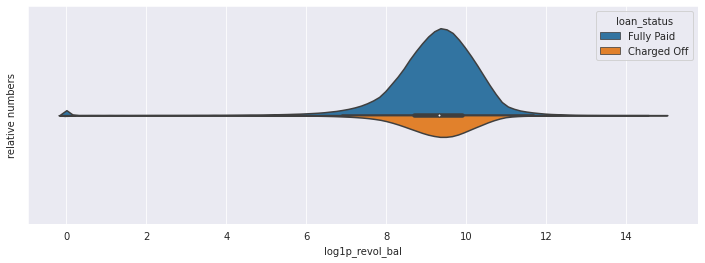

In [ ]:
featVis(keep_list[33], 'numerical', numlog=True)

In [ ]:
encoding(keep_list[33], num_cols, numlog=True)

#### 1.3.6.34 revol_util

In [ ]:
featInfo(keep_list[34])

revol_util:	Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

                 count       mean        std  min   25%   50%   75%    max
loan_status                                                               
Charged Off   268379.0  54.758433  23.865982  0.0  37.4  55.5  73.1  366.6
Fully Paid   1076074.0  51.074671  24.626821  0.0  32.5  51.3  70.1  892.3 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268379      180   0.067024
Fully Paid   1076751  1076074      677   0.062874


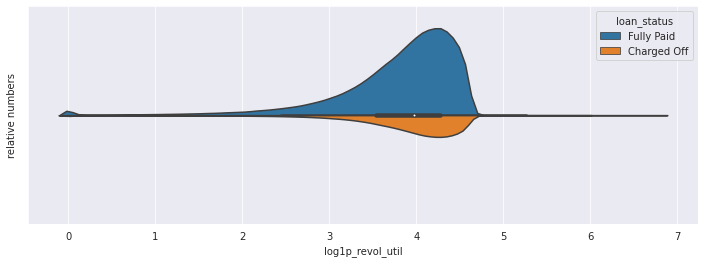

In [ ]:
featVis(keep_list[34], 'numerical', numlog=True)

In [ ]:
encoding(keep_list[34], num_cols, numlog=True)

#### 1.3.6.35 sub_grade

In [ ]:
featInfo(keep_list[35])

sub_grade:	LC assigned loan subgrade

               count unique top   freq
loan_status                           
Charged Off   268559     35  C4  18546
Fully Paid   1076751     35  B3  71203 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


   sub_grade  loan_status  count          %
0         A1  Charged Off   1408   3.223591
1         A1   Fully Paid  42270  96.776409
2         A2  Charged Off   1734   4.664049
3         A2   Fully Paid  35444  95.335951
4         A3  Charged Off   2093   5.508475
..       ...          ...    ...        ...
65        G3   Fully Paid    785  48.636927
66        G4  Charged Off    655  51.171875
67        G4   Fully Paid    625  48.828125
68        G5  Charged Off    595  53.603604
69        G5   Fully Paid    515  46.396396

[70 rows x 4 columns]


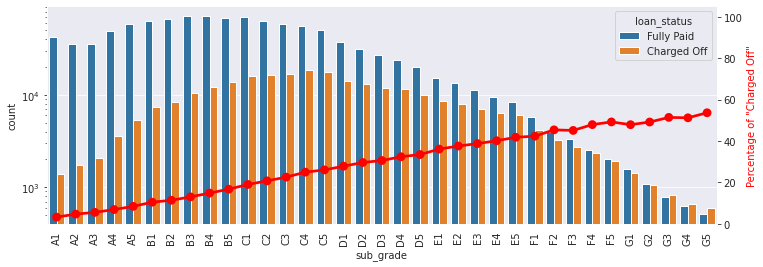

In [ ]:
featVis(keep_list[35], rotation=90)

In [ ]:
encoding(keep_list[35], cat_cols)

#### 1.3.6.36 term

In [ ]:
featInfo(keep_list[36])

term:	The number of payments on the loan. Values are in months and can be either 36 or 60.

               count unique         top    freq
loan_status                                    
Charged Off   268559      2   36 months  163252
Fully Paid   1076751      2   36 months  857491 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


         term  loan_status   count          %
0   36 months  Charged Off  163252  15.993448
1   36 months   Fully Paid  857491  84.006552
2   60 months  Charged Off  105307  32.445381
3   60 months   Fully Paid  219260  67.554619


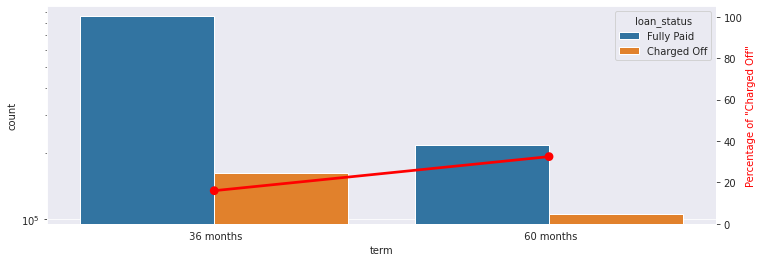

In [ ]:
featVis(keep_list[36])

In [ ]:
encoding(keep_list[36], cat_cols)

#### 1.3.6.37 title

In [ ]:
featInfo(keep_list[37])

title:	The loan title provided by the borrower

               count unique                 top    freq
loan_status                                            
Charged Off   263726  12045  Debt consolidation  144161
Fully Paid   1064925  53735  Debt consolidation  516799 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   263726     4833   1.799605
Fully Paid   1076751  1064925    11826   1.098304


In [ ]:
drop_list.add(keep_list[37])

#### 1.3.6.38 tot_coll_amt

In [ ]:
featInfo(keep_list[38])

tot_coll_amt:	Total collection amounts ever owed

                 count        mean           std  min  25%  50%  75%        max
loan_status                                                                    
Charged Off   258241.0  239.577186   1775.085964  0.0  0.0  0.0  0.0   146917.0
Fully Paid   1019542.0  251.870394  12355.035064  0.0  0.0  0.0  0.0  9152545.0 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   258241    10318   3.841986
Fully Paid   1076751  1019542    57209   5.313113


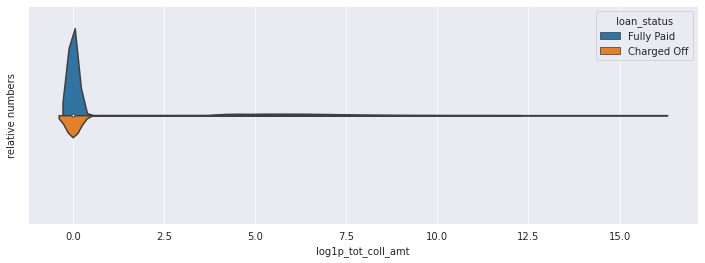

In [ ]:
featVis(keep_list[38], 'numerical', numlog=True)

In [ ]:
encoding(keep_list[38], num_cols, numlog=True)

#### 1.3.6.39 tot_cur_bal

In [ ]:
featInfo(keep_list[39])

tot_cur_bal:	Total current balance of all accounts

                 count           mean  ...       75%        max
loan_status                            ...                     
Charged Off   258241.0  118843.247637  ...  175030.0  3437283.0
Fully Paid   1019542.0  146779.741576  ...  219274.0  8000078.0

[2 rows x 8 columns] 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   258241    10318   3.841986
Fully Paid   1076751  1019542    57209   5.313113


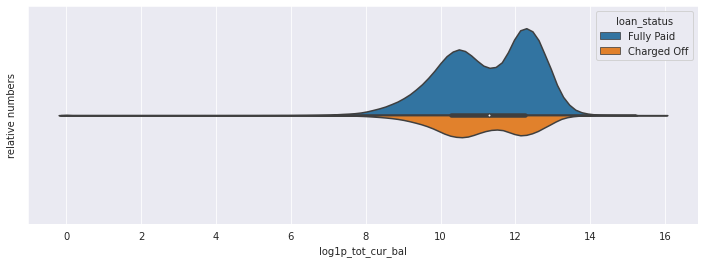

In [ ]:
featVis(keep_list[39], 'numerical', numlog=True)

In [ ]:
encoding(keep_list[39], num_cols, numlog=True)

#### 1.3.6.40 total_acc

In [ ]:
featInfo(keep_list[40])

total_acc:	The total number of credit lines currently in the borrower's credit file

                 count       mean        std  min   25%   50%   75%    max
loan_status                                                               
Charged Off   268559.0  24.709356  12.117364  2.0  16.0  23.0  31.0  176.0
Fully Paid   1076751.0  25.048551  11.967683  2.0  16.0  23.0  32.0  162.0 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


     total_acc  loan_status  count           %
0          2.0  Charged Off    108   33.027523
1          2.0   Fully Paid    219   66.972477
2          3.0  Charged Off    327   25.095932
3          3.0   Fully Paid    976   74.904068
4          4.0  Charged Off   1091   22.625467
..         ...          ...    ...         ...
256      156.0   Fully Paid      1  100.000000
257      162.0   Fully Paid      1  100.000000
258      169.0  Charged Off      1  100.000000
259      173.0  Charged Off      1  100.000000
260      176.0  Charged Off      1  100.000000

[261 rows x 4 columns]


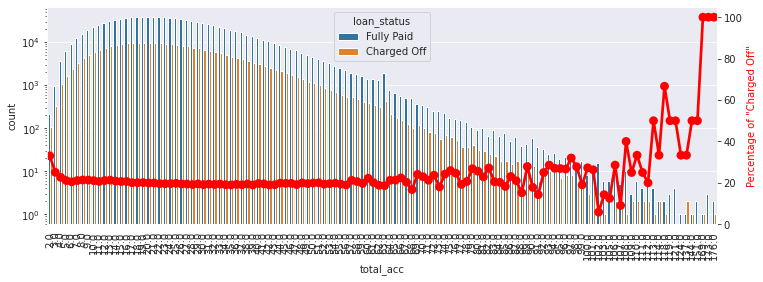

In [ ]:
featVis(keep_list[40], rotation=90)

In [ ]:
encoding(keep_list[40], cat_cols)

#### 1.3.6.41 total_pymnt

In [ ]:
featInfo(keep_list[41])

total_pymnt:	Payments received to date for total amount funded

                 count          mean  ...          75%           max
loan_status                           ...                           
Charged Off   268559.0   8291.083571  ...  11153.85000  61947.529797
Fully Paid   1076751.0  16453.244341  ...  22440.54134  63296.877917

[2 rows x 8 columns] 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


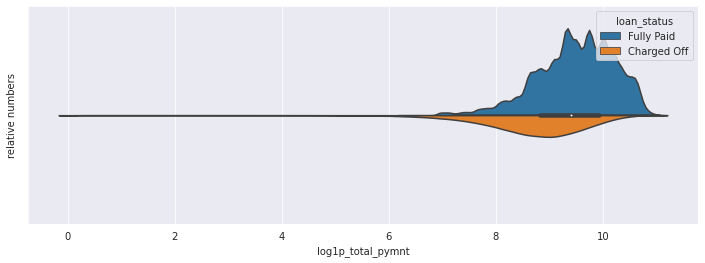

In [ ]:
featVis(keep_list[41], 'numerical', numlog=True)

In [ ]:
encoding(keep_list[41], num_cols, numlog=True)

#### 1.3.6.42 total_pymnt_inv

In [ ]:
featInfo(keep_list[42])

total_pymnt_inv:	Payments received to date for portion of total amount funded by investors

                 count          mean  ...       75%       max
loan_status                           ...                    
Charged Off   268559.0   8277.379175  ...  11139.85  61947.53
Fully Paid   1076751.0  16427.102300  ...  22420.13  63296.88

[2 rows x 8 columns] 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


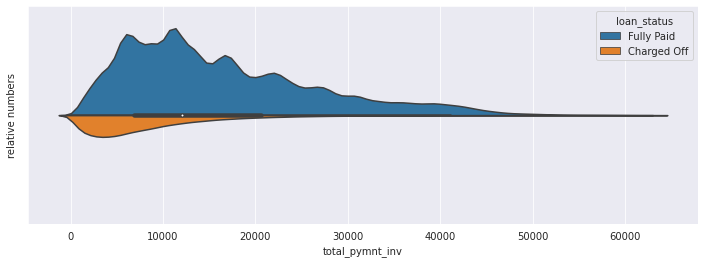

In [ ]:
featVis(keep_list[42], 'numerical')

In [ ]:
print(df_loan[keep_list[41:43]].corr())
drop_list.add(keep_list[42])

                 total_pymnt  total_pymnt_inv
total_pymnt         1.000000         0.999293
total_pymnt_inv     0.999293         1.000000


#### 1.3.6.43 rec_int

In [ ]:
featInfo(keep_list[43])

total_rec_int:	Interest received to date

                 count         mean          std  ...      50%      75%       max
loan_status                                       ...                            
Charged Off   268559.0  2689.126532  2727.412484  ...  1799.04  3573.28  26822.38
Fully Paid   1076751.0  2326.569791  2563.327655  ...  1520.36  2905.51  28192.50

[2 rows x 8 columns] 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


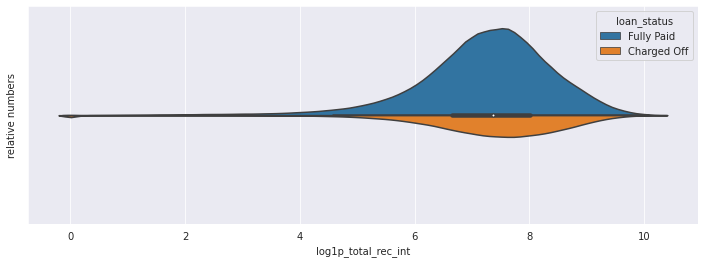

In [ ]:
featVis(keep_list[43], 'numerical', numlog=True)

In [ ]:
encoding(keep_list[43], num_cols, numlog=True)

#### 1.3.6.44 total_rec_late_fee

In [ ]:
featInfo(keep_list[44])

total_rec_late_fee:	Late fees received to date

                 count      mean        std  ...  50%  75%      max
loan_status                                  ...                   
Charged Off   268559.0  4.622596  16.753323  ...  0.0  0.0   874.17
Fully Paid   1076751.0  0.824845   8.477710  ...  0.0  0.0  1188.83

[2 rows x 8 columns] 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


There are 4 values below zero: 26167    -2.000000e-10
302725   -5.100000e-09
376033   -1.800000e-09
684019   -2.000000e-09
Name: total_rec_late_fee, dtype: float64


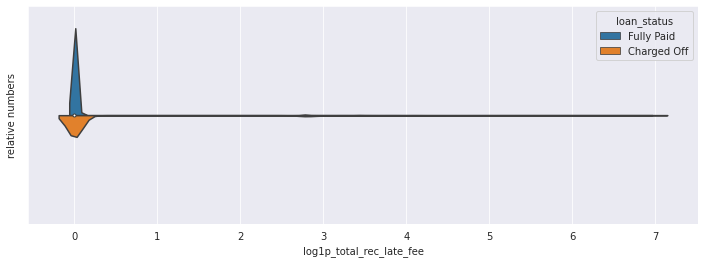

In [ ]:
featVis(keep_list[44], 'numerical', numlog=True)

In [ ]:
encoding(keep_list[44], num_cols, numlog=True)

#### 1.3.6.45 total_rec_prncp

In [ ]:
featInfo(keep_list[45])

total_rec_prncp:	Principal received to date

                 count          mean          std  ...       50%       75%       max
loan_status                                        ...                              
Charged Off   268559.0   4387.877516  4122.557902  ...   3157.31   5900.86  39989.79
Fully Paid   1076751.0  14125.849707  8664.976860  ...  12000.00  20000.00  40000.00

[2 rows x 8 columns] 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


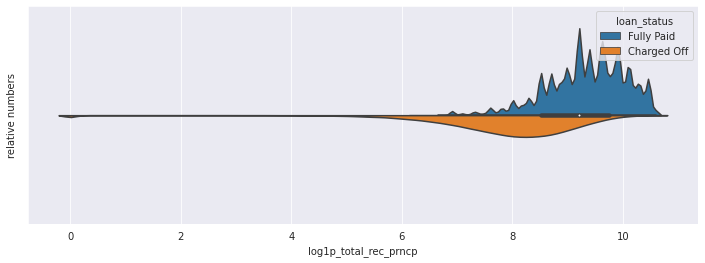

In [ ]:
featVis(keep_list[45], 'numerical', numlog=True)

In [ ]:
encoding(keep_list[45], num_cols, numlog=True)

#### 1.3.6.46 url (will be dropped)

In [ ]:
featInfo(keep_list[46])

url:	URL for the LC page with listing data.

               count  ... freq
loan_status           ...     
Charged Off   268559  ...    1
Fully Paid   1076751  ...    1

[2 rows x 4 columns] 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0        0.0
Fully Paid   1076751  1076751        0        0.0


In [ ]:
drop_list.add(keep_list[46])

#### 1.3.6.47 zip_code (will be dropped)

In [ ]:
featInfo(keep_list[47])

zip_code:	The first 3 numbers of the zip code provided by the borrower in the loan application.

               count unique    top   freq
loan_status                              
Charged Off   268559    900  112xx   3089
Fully Paid   1076750    934  945xx  12257 

                size    count  missing  missing %
loan_status                                      
Charged Off   268559   268559        0   0.000000
Fully Paid   1076751  1076750        1   0.000093


In [ ]:
drop_list.add(keep_list[47])

### 1.3.7 Data Cleaning

#### 1.3.7.1 Make sure columns are correct

In [ ]:
all = set(df_loan.columns)
print(num_cols[0] - all)
print(cat_cols[0] - all)
print(cat_cols[1] - all)
print(drop_list - all)
print(all - num_cols[0] - cat_cols[0] - cat_cols[1] - drop_list)

set()
set()
set()
set()
{'issue_d', 'y'}


#### 1.3.7.2 Cleaning

In [ ]:
df_loan.drop(labels=drop_list, axis=1, inplace=True)
df_loan.isnull().sum()

acc_now_delinq                   0
addr_state                       0
application_type                 0
collections_12_mths_ex_med       0
delinq_2yrs                      0
earliest_cr_line                 0
emp_length                       0
home_ownership                   0
initial_list_status              0
inq_last_6mths                   0
int_rate                         0
issue_d                          0
open_acc                         0
pub_rec                          0
purpose                          0
sub_grade                        0
term                             0
total_acc                        0
y                                0
log1p_annual_inc                 0
log1p_collection_recovery_fee    0
log1p_dti                        0
log1p_fico_range_high            0
log1p_funded_amnt                0
log1p_installment                0
last_credit_pull_month           0
log1p_last_fico_range_high       0
log1p_last_fico_range_low        0
log1p_last_pymnt_amn

## 1.4 Data Preprocessing

### 1.4.1 Different feature columns

In [ ]:
num_cols = list(num_cols[0])
cat_onehot = list(cat_cols[0])
cat_target = list(cat_cols[1])
print(f'{num_cols}\n{cat_onehot}\n{cat_target}')
#X_train = df_loan[cat_target + ['y', 'issue_d']]

['log1p_total_rec_late_fee', 'log1p_tot_cur_bal', 'log1p_total_pymnt', 'log1p_last_fico_range_high', 'log1p_last_pymnt_amnt', 'log1p_collection_recovery_fee', 'log1p_loan_amnt', 'log1p_annual_inc', 'log1p_fico_range_high', 'log1p_funded_amnt', 'log1p_installment', 'log1p_recoveries', 'log1p_dti', 'log1p_total_rec_prncp', 'log1p_revol_util', 'log1p_last_fico_range_low', 'log1p_total_rec_int', 'int_rate', 'log1p_revol_bal', 'log1p_tot_coll_amt']
['initial_list_status', 'home_ownership', 'inq_last_6mths', 'term', 'acc_now_delinq', 'application_type']
['purpose', 'sub_grade', 'emp_length', 'last_credit_pull_month', 'pub_rec', 'collections_12_mths_ex_med', 'total_acc', 'addr_state', 'earliest_cr_line', 'delinq_2yrs', 'open_acc']


### 1.4.2 Scale numerical features

In [ ]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
df_loan[num_cols] = sc.fit_transform(df_loan[num_cols])

### 1.4.3 One-hot encoding

In [ ]:
df_loan = pd.get_dummies(df_loan, columns=cat_onehot)

In [ ]:
df_loan.shape

(1345310, 63)

### 1.4.4 Split data into train and validation data by "issue_d" column

In [ ]:
df_loan['issue_d'].describe()

count                 1345310
unique                    139
top       2016-03-01 00:00:00
freq                    48937
first     2007-06-01 00:00:00
last      2018-12-01 00:00:00
Name: issue_d, dtype: object

In [ ]:
X_train = df_loan.loc[df_loan['issue_d'] <= df_loan['issue_d'].quantile(0.9)]
X_valid = df_loan.loc[df_loan['issue_d'] > df_loan['issue_d'].quantile(0.9)]
print(f'train_ratio = {X_train.shape[0] / df_loan.shape[0]}')
X_train['issue_d'].describe()

train_ratio = 0.9002066438218701


count                 1211057
unique                    121
top       2016-03-01 00:00:00
freq                    48937
first     2007-06-01 00:00:00
last      2017-06-01 00:00:00
Name: issue_d, dtype: object

In [ ]:
y_train = X_train['y']
X_train.drop(labels=['issue_d', 'y'], axis=1, inplace=True)

y_valid = X_valid['y']
X_valid.drop(labels=['issue_d', 'y'], axis=1, inplace=True)

print(f'training data size: {X_train.shape}')
print(f'validation data size: {X_valid.shape}')
print(f'y_train.mean: {y_train.mean():.3f}, y_valid.mean: {y_valid.mean():.3f}')

training data size: (1211057, 61)
validation data size: (134253, 61)
y_train.mean: 0.200, y_valid.mean: 0.199


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## 1.5 Correlation between features and Charge Off

                          feature      corr  abs_corr             F     p_val
22               log1p_recoveries  0.793607  0.793607  2.060405e+06  0.000000
12  log1p_collection_recovery_fee  0.766661  0.766661  1.726750e+06  0.000000
18     log1p_last_fico_range_high -0.558205  0.558205  5.481579e+05  0.000000
30          log1p_total_rec_prncp -0.554156  0.554156  5.367240e+05  0.000000
20          log1p_last_pymnt_amnt -0.382560  0.382560  2.076271e+05  0.000000
..                            ...       ...       ...           ...       ...
53            acc_now_delinq_14.0 -0.000454  0.000454  2.495698e-01  0.617378
36           home_ownership_OTHER -0.000333  0.000333  1.346539e-01  0.713655
47             inq_last_6mths_8.0 -0.000191  0.000191  4.413480e-02  0.833603
33             home_ownership_ANY  0.000038  0.000038  1.778389e-03  0.966362
56             acc_now_delinq_4.0  0.000002  0.000002  4.741696e-06  0.998263

[61 rows x 5 columns]


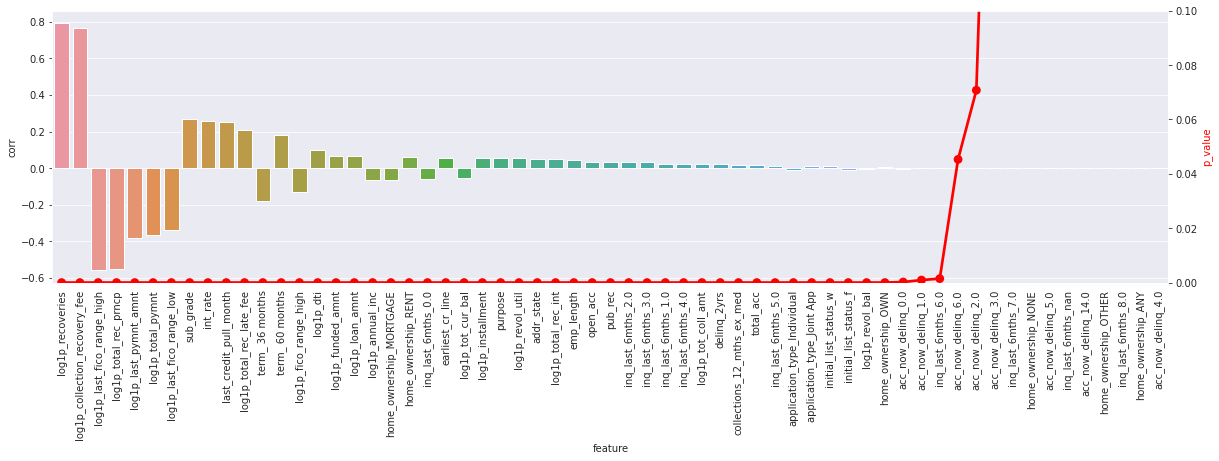

In [ ]:
from sklearn.feature_selection import f_classif

corr = []
for col in X_train.columns:
  corr.append([col, X_train[col].corr(y_train)])
corr = pd.DataFrame(data=corr, columns=['feature', 'corr'])
corr['abs_corr'] = abs(corr['corr'])
corr['F'], corr['p_val'] = f_classif(X_train, y_train)
corr.sort_values(by='abs_corr', ascending=False, inplace=True)

fig = plt.figure(figsize=[20, 5])
ax = sns.barplot(x='feature', y='corr', data=corr)
ax.tick_params(axis='x', rotation=90)

ax2 = ax.twinx()
ax2.grid(False)
ax2 = sns.pointplot(x='feature', y='p_val', color='red', data=corr)
ax2.set_ylim([0, 0.1])
ax2.set_ylabel('p_value', color='r')

print(corr)

# **Part 2: Models**

## 2.1 Import packages

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

## 2.2 Gradient Boosting Classifier

### 2.2.1 Model buidling and training

In [ ]:
param_GB = {'n_estimators': 20,
            'max_depth': 25,
            'max_leaf_nodes': 8,
            'min_samples_split': 5,
            'learning_rate': 0.05,
            'random_state': 42}
clf_GB = GradientBoostingClassifier(**param_GB)
clf_GB.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=25,
                           max_features=None, max_leaf_nodes=8,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=5,
                           min_weight_fraction_leaf=0.0, n_estimators=20,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### 2.2.2 Model evaluation

In [ ]:
y_GB = clf_GB.predict(X_valid)

print('Confusion Matrix:\n', '='*40)
confM = pd.DataFrame({'pred': y_GB, 'actual': y_valid})
confM = confM.groupby('pred')['actual'].agg([lambda x: x.size-x.sum(), 'sum'])
confM.columns = ['actual_0', 'actual_1']
print(confM)

print('\nClassification Report\n', '='*40)
print(classification_report(y_valid, y_GB))

Confusion Matrix:
      actual_0  actual_1
pred                    
0       107572      4266
1            0     22415

Classification Report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    107572
           1       1.00      0.84      0.91     26681

    accuracy                           0.97    134253
   macro avg       0.98      0.92      0.95    134253
weighted avg       0.97      0.97      0.97    134253



#### ROC curve

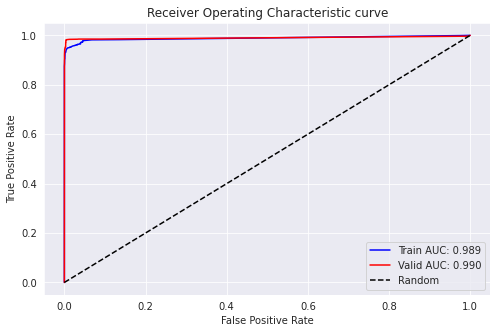

In [ ]:
assert clf_GB.classes_[1] == 1 # confirm the second column is "1" class

fig = plt.figure(figsize=[8, 5])

p_pred = clf_GB.predict_proba(X_train)[:, 1]
fpr, tpr, thresh = roc_curve(y_train, p_pred)
auc = roc_auc_score(y_train, p_pred)
plt.plot(fpr, tpr, 'b-', label=f'Train AUC: {auc:.3f}')

p_pred = clf_GB.predict_proba(X_valid)[:, 1]
fpr, tpr, thresh = roc_curve(y_valid, p_pred)
auc = roc_auc_score(y_valid, p_pred)
plt.plot(fpr, tpr, 'r-', label=f'Valid AUC: {auc:.3f}')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic curve")
plt.legend(loc="lower right")
plt.show()

#### Feature importance

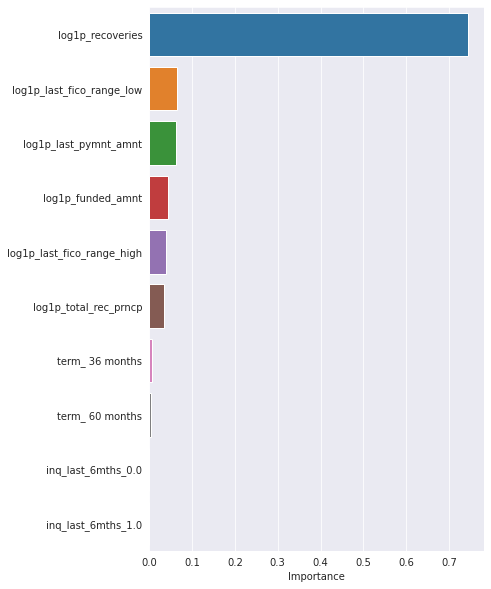

In [ ]:
feat_im = pd.DataFrame({'feat_nm': X_train.columns,
                        'Importance': clf_GB.feature_importances_})
feat_im.sort_values(by='Importance', ascending=False, inplace=True)

fig = plt.figure(figsize=[6, 10])
sns.barplot(x='Importance', y='feat_nm', data=feat_im[:10])
plt.ylabel("")
plt.show()

## 2.3 Random Forest Classifier

### 2.3.1 Model building and training

In [ ]:
wgt_01 = sum(y_train==0) / sum(y_train)
print(f'samples_class_0 : samples_class_1 = {wgt_01:.2f}')

param_RF = {"n_estimators": 100,
            "max_depth": 25,
            "max_features": 10,
            "class_weight": {0:1, 1:wgt_01/2}}
clf_RF = RandomForestClassifier(**param_RF)
clf_RF.fit(X_train, y_train)

samples_class_0 : samples_class_1 = 4.01


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1, 1: 2.00344595209155},
                       criterion='gini', max_depth=25, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### 2.3.2 Model evaluation

In [ ]:
y_RF = clf_RF.predict(X_valid)

print('Confusion Matrix:\n', '='*40)
confM = pd.DataFrame({'pred': y_RF, 'actual': y_valid})
confM = confM.groupby('pred')['actual'].agg([lambda x: x.size-x.sum(), 'sum'])
confM.columns = ['actual_0', 'actual_1']
print(confM)

print('\nClassification Report\n', '='*40)
print(classification_report(y_valid, y_RF))

Confusion Matrix:
      actual_0  actual_1
pred                    
0       107572        58
1            0     26623

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    107572
           1       1.00      1.00      1.00     26681

    accuracy                           1.00    134253
   macro avg       1.00      1.00      1.00    134253
weighted avg       1.00      1.00      1.00    134253



#### ROC curve

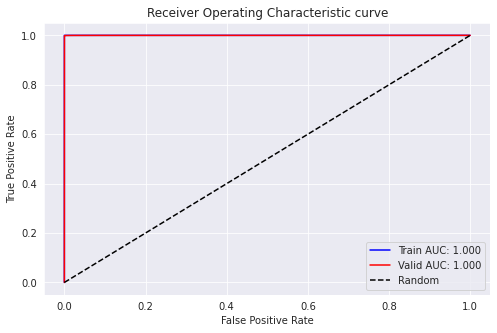

In [ ]:
assert clf_RF.classes_[1] == 1 # confirm the second column is "1" class

fig = plt.figure(figsize=[8, 5])

p_pred = clf_RF.predict_proba(X_train)[:, 1]
fpr, tpr, thresh = roc_curve(y_train, p_pred)
auc = roc_auc_score(y_train, p_pred)
plt.plot(fpr, tpr, 'b-', label=f'Train AUC: {auc:.3f}')

p_pred = clf_RF.predict_proba(X_valid)[:, 1]
fpr, tpr, thresh = roc_curve(y_valid, p_pred)
auc = roc_auc_score(y_valid, p_pred)
plt.plot(fpr, tpr, 'r-', label=f'Valid AUC: {auc:.3f}')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic curve")
plt.legend(loc="lower right")
plt.show()

#### Feature importance

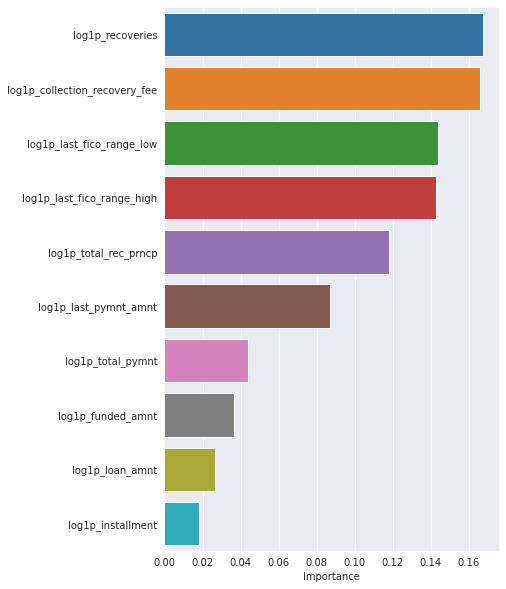

In [ ]:
feat_im = pd.DataFrame({'feat_nm': X_train.columns,
                        'Importance': clf_RF.feature_importances_})
feat_im.sort_values(by='Importance', ascending=False, inplace=True)

fig = plt.figure(figsize=[6, 10])
sns.barplot(x='Importance', y='feat_nm', data=feat_im[:10])
plt.ylabel("")
plt.show()

## 2.4 Deep Neural Network

In [ ]:
param_DNN = {'hidden_layer_sizes': (64, 32),
             'random_state': 42}
clf_DNN = MLPClassifier(**param_DNN)
clf_DNN.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(64, 32), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

### 2.4.1 Model evaluation

In [ ]:
y_DNN = clf_DNN.predict(X_valid)

print('Confusion Matrix:\n', '='*40)
confM = pd.DataFrame({'pred': y_DNN, 'actual': y_valid})
confM = confM.groupby('pred')['actual'].agg([lambda x: x.size-x.sum(), 'sum'])
confM.columns = ['actual_0', 'actual_1']
print(confM)

print('\nClassification Report\n', '='*40)
print(classification_report(y_valid, y_DNN))

Confusion Matrix:
      actual_0  actual_1
pred                    
0       107570        36
1            2     26645

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    107572
           1       1.00      1.00      1.00     26681

    accuracy                           1.00    134253
   macro avg       1.00      1.00      1.00    134253
weighted avg       1.00      1.00      1.00    134253



#### ROC curve

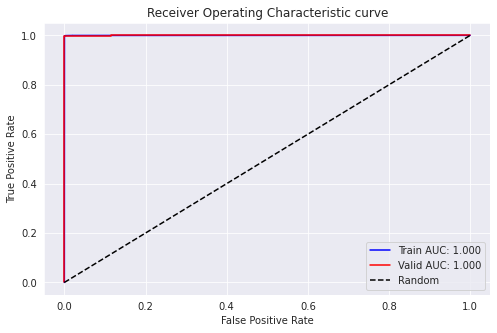

In [ ]:
assert clf_DNN.classes_[1] == 1 # confirm the second column is "1" class

fig = plt.figure(figsize=[8, 5])

p_pred = clf_DNN.predict_proba(X_train)[:, 1]
fpr, tpr, thresh = roc_curve(y_train, p_pred)
auc = roc_auc_score(y_train, p_pred)
plt.plot(fpr, tpr, 'b-', label=f'Train AUC: {auc:.3f}')

p_pred = clf_DNN.predict_proba(X_valid)[:, 1]
fpr, tpr, thresh = roc_curve(y_valid, p_pred)
auc = roc_auc_score(y_valid, p_pred)
plt.plot(fpr, tpr, 'r-', label=f'Valid AUC: {auc:.3f}')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic curve")
plt.legend(loc="lower right")
plt.show()